In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import torchvision.transforms.functional as TF
import random
import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

mps


In [5]:
# Normalization statistics for ImageNet data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# Load dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split training data into training and validation sets
train_set, val_set = random_split(train_data, [40000, 10000])  

# Define dataloaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### To be solved: 
In the following eval() function, the target_percentage is calculated by total_target/total. I(Jamie) am not sure if we should set it to total_misclassified_target/total. In the test() function I wrote, I set targeted_attack_rate = total_targeted_hits(total_misclassified_target) / total. In actual, eval() and test() are pretty similar and can be considered to combine. I do not spend time combining them.

In [48]:
# This function evaluates a model's accuracy on the validation set
# Optionally, one can pass an adversarial patch as an argument to evaluate the model's performance against a patch attack
def eval(model, patch=None, target_class=None, apply=apply):
  # Stats to use to calculate accuracy after the eval loop
  total_correct = 0
  total = 0
  total_target = 0
  # Put model on GPU and switch to eval mode
  model = model.to(device)
  model.eval()
  # Evaluation loop
  with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
      # Put data on GPU
      images = images.to(device)
      if patch is not None:
        images = apply(patch, images)
      labels = labels.to(device)
      # Make predictions
      predictions = model(images)
      predictions = torch.argmax(predictions, dim=1)
      # Update validation accuracy information
      total += len(images)
      num_correct = (predictions == labels).float().sum().item()
      total_correct += num_correct
      if target_class is not None:
        target = torch.zeros(len(images), dtype=torch.long).fill_(target_class).to(device)
        num_target = (predictions == target).float().sum().item()
        total_target += num_target
  # If evaluating the effects of a targeted patch attach, it is nice to see whether or not the model is classifying lots of examples to the target class
  if target_class is not None:
    target_percentage = total_target / total
    print(f"Percentage of samples predicted as target class {target_class}: {100 * target_percentage}")
  # Calculate accuracy
  accuracy = total_correct / total
  return accuracy

In [49]:
# This function is designed to take in a pretrained ResNet model and fine-tune its weights for the CIFAR-10 dataset
# The idea is to fine-tune ResNet for the CIFAR-10 dataset (accuracy should be around 82%) and then degrade that performance via an adversarial patch attack
def fine_tune_for_cifar10(model, num_epochs=30, model_path="resnet18.pth"):
  # Put model on GPU and put model in training mode
  model = model.to(device)
  model.train()
  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
  best_accuracy = 0.0
  best_model_path = model_path
  # Training loop
  for i in range(num_epochs):
    # Stats to use for calculating accuracy
    total_correct = 0
    total = 0
    # Iterate through each batch of data
    for batch_idx, (images, labels) in enumerate(train_loader):
      # Put data on GPU
      images = images.to(device)
      labels = labels.to(device)
      # Make predictions
      predictions = model(images)
      # Calculate loss for the batch
      loss = criterion(predictions, labels)
      # Gradient descent
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # Update training accuracy information
      total += len(images)
      predictions = torch.argmax(predictions, dim=1)
      num_correct = (predictions == labels).float().sum().item()
      total_correct += num_correct
    # Print training accuracy
    print(f"Epoch {str(i + 1)}: Training accuracy = {str(total_correct / total)}")
    # Print validation accuracy
    val_accuracy = eval(model, patch=None, target_class=None)
    print(f"Validation accuracy: {str(val_accuracy)}")
    
    if val_accuracy > best_accuracy:
      best_accuracy = val_accuracy
      torch.save(model.state_dict(), best_model_path)
      print(f"Saved new best model with accuracy: {best_accuracy:.4f}")    



In [50]:
# Apply patch to a batch of images
def apply(patch, batch_of_images):
  num_images = batch_of_images.shape[0]
  patch_size = patch.shape[1]
  # Iterate through each image in the batch
  for i in range(num_images):
    # Rotate the patch by a random number of degrees
    degree = random.uniform(0, 360)
    patch_rotated = TF.rotate(patch, angle=degree)
    # Randomly choose an (x, y) coordinate on the 32x32 CIFAR-10 image
    # This coordinate will be where the top left corner of the rotated patch goes
    top_left_x = random.randint(0, 31 - patch_size)
    top_left_y = random.randint(0, 31 - patch_size)
    # Apply the randomly rotated patch at the random location
    batch_of_images[i, :, top_left_x:top_left_x+patch_size, top_left_y:top_left_y+patch_size] = patch
  return batch_of_images

In [51]:
# Function to load the best model checkpoint
def load_model(model, path, device="cuda"):
    model.load_state_dict(torch.load(path, map_location=device))
    model = model.to(device)
    return model

In [52]:
# This function fine-tunes an adversarial patch against a provided whitebox model
# Model accuracy against the patch attack is reported at each step
def generate_adversarial_patch(model, patch_size, target_class=None, num_epochs=10, lr=1e-1, momentum=0.8, apply=apply):
  model = model.to(device)
  model.train()
  
  # Initialize patch to all zeros
  patch = nn.Parameter(torch.zeros(3, patch_size, patch_size), requires_grad=True)
  optimizer = optim.SGD([patch], lr, momentum)
  criterion = nn.CrossEntropyLoss()
  # Optimize the patch
  for i in range(num_epochs):
    print(f"Epoch {str(i + 1)}")
    for batch_idx, (images, labels) in enumerate(train_loader):
      # Put data on the GPU
      images = images.to(device)
      labels = labels.to(device)
      # Apply the patch at a random location and with a random rotation for each image in the batch
      images = apply(patch, images)
      # Make predictions on the patched images
      predictions = resnet18(images)
      # For an untargeted attack, create false labels by incrementing the true labels by 1
      if target_class is None:
        false_labels = (labels + 1) % 10
      # For a targeted attack, set all the false labels to the target class
      else:
        false_labels = torch.zeros(len(images), dtype=torch.long).fill_(target_class).to(device)
      # Tune the patch
      loss = criterion(predictions, false_labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    # See how the patch performs
    print(f"Target class: {target_class}")
    accuracy = eval(model, patch=patch, target_class=target_class)
    print(f"Accuracy: {str(accuracy)}\n")
  return patch

In [53]:
# This function test the model accuracy on clean test dataset
# Optinally, if pass in an adversarial patch, this function test model accuracy, untargetted and targetted ASR
def test(model, patch=None, target_class=None, apply=apply):
  model.eval()
  total = 0
  total_correct = 0
  total_misclassified = 0
  total_targeted_hits = 0

  with torch.no_grad():
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      
      if patch is not None:
        images = apply(patch, images)

      outputs = model(images)
      predictions = torch.argmax(outputs, dim=1)
      total += labels.size(0)
      total_correct += (predictions == labels).sum().item()
      total_misclassified += (predictions != labels).sum().item()

      if target_class is not None:
        targeted_misclassifications = ((predictions != labels) & (predictions == target_class))
        total_targeted_hits += targeted_misclassifications.sum().item()

  adversarial_accuracy = total_correct / total
  untargeted_attack_rate = total_misclassified / total

  if patch is not None:
    print(f"Model accuracy with adversarial patch: {adversarial_accuracy * 100:.2f}%")
    print(f"Untargeted attack success rate on test set: {untargeted_attack_rate * 100:.2f}%")
  else:
    print(f"Model accuracy on clean test set: {adversarial_accuracy * 100:.2f}%")

  if target_class is not None:
    targeted_attack_rate = total_targeted_hits / total
    print(f"Targeted attack success rate on test set for class {target_class}: {targeted_attack_rate * 100:.2f}%")
    return adversarial_accuracy, untargeted_attack_rate, targeted_attack_rate
  else:
    return adversarial_accuracy, untargeted_attack_rate

In [13]:
# This function takes in a patch and outputs it visually
def visualize_patch(patch):
    patch = patch.detach() 
    patch = (patch - patch.min()) / (patch.max() - patch.min())  # Normalize to [0, 1]

    # Convert to numpy and transpose dimensions from [C, H, W] to [H, W, C] for visualization
    patch_np = patch.cpu().numpy().transpose(1, 2, 0)
    plt.imshow(patch_np)
    plt.axis('off') 
    plt.show()


In [14]:
# This function is used to plot the (untargeted or targeted) ASR v.s. patch size 
def plot_asr_vs_patch_size(patch_sizes, asr_results):
    asr_values = [asr_results[size] * 100 for size in patch_sizes]
    plt.figure(figsize=(6,4))
    plt.plot(patch_sizes, asr_values, marker='o', linestyle='-', color='b')
    plt.title('Attack Success Rate vs Patch Size')
    plt.xlabel('Patch Size (pixels)')
    plt.ylabel('ASR (%)')
    plt.grid(True)
    plt.xticks(patch_sizes)  
    plt.show()


## Untargetted patch attack on ResNet18, patch size = 8

### First, load the pretrained resnet18 and finetune it. After finetuning it with 30 epochs, the test accuracy should achieve ~82%

In [15]:
# # Load pre-trained model
# resnet18 = models.resnet18(weights="DEFAULT")

# # ResNet is trained on ImageNet, which has 1000 classes
# # So we need to modify the output layer for CIFAR-10, which has 10 classes
# resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

# # Finetune the model
# fine_tune_for_cifar10(model=resnet18, num_epochs=30, model_path="resnet18.pth")
# # Load best model checkpoint
# resnet18 = load_model(resnet18, "resnet18.pth", device=device)
# # Test model performance on clean test dataset
# test(model=resnet18, patch=None, target_class=None)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/hiepnguyen/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


Epoch 1: Training accuracy = 0.26435
Validation accuracy: 0.3354
Saved new best model with accuracy: 0.3354
Epoch 2: Training accuracy = 0.417025
Validation accuracy: 0.4756
Saved new best model with accuracy: 0.4756
Epoch 3: Training accuracy = 0.520325
Validation accuracy: 0.5645
Saved new best model with accuracy: 0.5645
Epoch 4: Training accuracy = 0.584325
Validation accuracy: 0.5668
Saved new best model with accuracy: 0.5668
Epoch 5: Training accuracy = 0.6268
Validation accuracy: 0.6243
Saved new best model with accuracy: 0.6243
Epoch 6: Training accuracy = 0.65055
Validation accuracy: 0.6638
Saved new best model with accuracy: 0.6638
Epoch 7: Training accuracy = 0.68375
Validation accuracy: 0.6854
Saved new best model with accuracy: 0.6854
Epoch 8: Training accuracy = 0.698125
Validation accuracy: 0.6851
Epoch 9: Training accuracy = 0.712125
Validation accuracy: 0.7064
Saved new best model with accuracy: 0.7064
Epoch 10: Training accuracy = 0.728375
Validation accuracy: 0.7243


(0.801, 0.199)

In [31]:
# Load pre-trained model
resnet18 = models.resnet18(weights="DEFAULT")
# Load best model checkpoint after fine-tuning
resnet18 = load_model(resnet18, "resnet18.pth", device=torch.device("mps"))
# Test model performance on clean test dataset
test(model=resnet18, patch=None, target_class=None)

Model accuracy on clean test set: 82.36%


(0.8236, 0.1764)

I tried to finetune again, and got 80.1%

### Generate untargetted adversarial patch of size 8*8. With this patch applied to images, the model accuracy degrades to ~20%; the untargeted ASR achieves ~80%

Epoch 1
Target class: None
Accuracy: 0.4849

Epoch 2
Target class: None
Accuracy: 0.3446

Epoch 3
Target class: None
Accuracy: 0.2827

Epoch 4
Target class: None
Accuracy: 0.2498

Epoch 5
Target class: None
Accuracy: 0.2257

Epoch 6
Target class: None
Accuracy: 0.2035

Epoch 7
Target class: None
Accuracy: 0.1864

Epoch 8
Target class: None
Accuracy: 0.1737

Epoch 9
Target class: None
Accuracy: 0.1687

Epoch 10
Target class: None
Accuracy: 0.1544



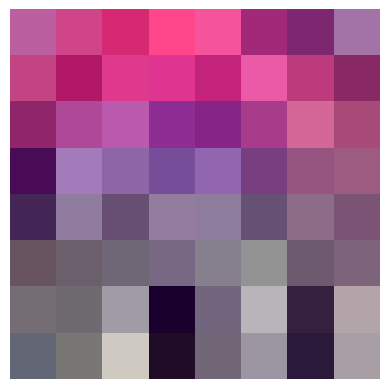

Model accuracy with adversarial patch: 17.94%
Untargeted attack success rate on test set: 82.06%


(0.1794, 0.8206)

In [35]:
# Generate adversarial patch
patch_untarget = generate_adversarial_patch(model=resnet18, patch_size=8, target_class=None, num_epochs=10, lr=1e-1, momentum=0.8)
# Visualize the generated patch
visualize_patch(patch_untarget)
# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_untarget, target_class=None)

### Generate targetted adversarial patch of size 8*8, target class is set to 5 here.  With this patch applied to images, the model accuracy degrades to ~16%; the untargeted ASR achieves ~84%, the targetted ASR achieves ~72%

Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 5.76
Accuracy: 0.5504

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 64.36
Accuracy: 0.2499

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 71.82
Accuracy: 0.2137

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 76.61
Accuracy: 0.1824

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 77.8
Accuracy: 0.1786

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 80.01
Accuracy: 0.1734

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 80.5
Accuracy: 0.1741

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 81.02000000000001
Accuracy: 0.1641

Epoch 9
Target class: 5
Percentage of samples predicted as target class 5: 82.96
Accuracy: 0.1575

Epoch 10
Target class: 5
Percentage of samples predicted as target class 5: 82.21000000000001
Accura

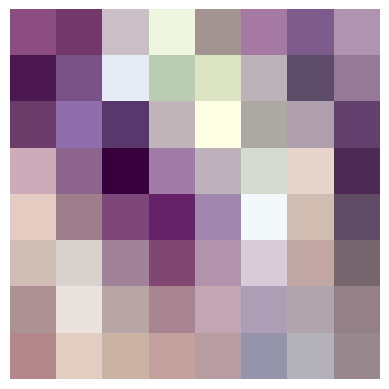

Model accuracy with adversarial patch: 16.55%
Untargeted attack success rate on test set: 83.45%
Targeted attack success rate on test set for class 5: 71.14%


(0.1655, 0.8345, 0.7114)

In [40]:
# Generate adversarial patch
patch_target = generate_adversarial_patch(model=resnet18, patch_size=8, target_class=5, num_epochs=10, lr=1e-1, momentum=0.8)
# Visualize the generated patch
visualize_patch(patch_target)
# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_target, target_class=5)

### Generate patches with side length of 3,5,7,10,13,16. Visualize patch_sizes v.s. untargeted ASR.

Epoch 1
Target class: None
Accuracy: 0.5982

Epoch 2
Target class: None
Accuracy: 0.5081

Epoch 3
Target class: None
Accuracy: 0.4407

Epoch 4
Target class: None
Accuracy: 0.3934

Epoch 5
Target class: None
Accuracy: 0.3668

Epoch 6
Target class: None
Accuracy: 0.3316

Epoch 7
Target class: None
Accuracy: 0.313

Epoch 8
Target class: None
Accuracy: 0.2874

Epoch 9
Target class: None
Accuracy: 0.2727

Epoch 10
Target class: None
Accuracy: 0.2512



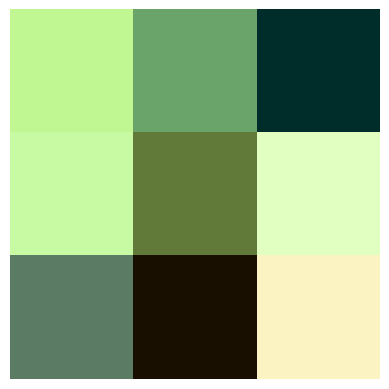

Model accuracy with adversarial patch: 28.18%
Untargeted attack success rate on test set: 71.82%
Epoch 1
Target class: None
Accuracy: 0.5421

Epoch 2
Target class: None
Accuracy: 0.4564

Epoch 3
Target class: None
Accuracy: 0.4099

Epoch 4
Target class: None
Accuracy: 0.3684

Epoch 5
Target class: None
Accuracy: 0.348

Epoch 6
Target class: None
Accuracy: 0.3373

Epoch 7
Target class: None
Accuracy: 0.32

Epoch 8
Target class: None
Accuracy: 0.2999

Epoch 9
Target class: None
Accuracy: 0.2816

Epoch 10
Target class: None
Accuracy: 0.2638



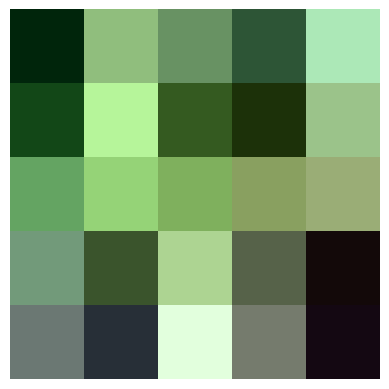

Model accuracy with adversarial patch: 29.85%
Untargeted attack success rate on test set: 70.15%
Epoch 1
Target class: None
Accuracy: 0.5154

Epoch 2
Target class: None
Accuracy: 0.4003

Epoch 3
Target class: None
Accuracy: 0.334

Epoch 4
Target class: None
Accuracy: 0.2888

Epoch 5
Target class: None
Accuracy: 0.2608

Epoch 6
Target class: None
Accuracy: 0.2421

Epoch 7
Target class: None
Accuracy: 0.2175

Epoch 8
Target class: None
Accuracy: 0.2132

Epoch 9
Target class: None
Accuracy: 0.1966

Epoch 10
Target class: None
Accuracy: 0.188



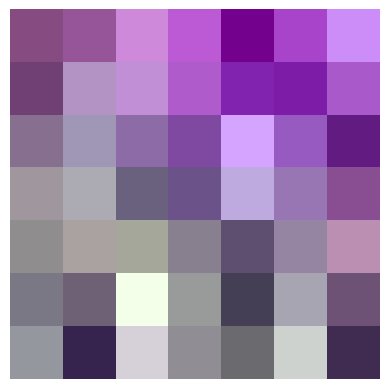

Model accuracy with adversarial patch: 21.03%
Untargeted attack success rate on test set: 78.97%
Epoch 1
Target class: None
Accuracy: 0.4646

Epoch 2
Target class: None
Accuracy: 0.3515

Epoch 3
Target class: None
Accuracy: 0.2698

Epoch 4
Target class: None
Accuracy: 0.2305

Epoch 5
Target class: None
Accuracy: 0.2045

Epoch 6
Target class: None
Accuracy: 0.1788

Epoch 7
Target class: None
Accuracy: 0.1765

Epoch 8
Target class: None
Accuracy: 0.1626

Epoch 9
Target class: None
Accuracy: 0.1588

Epoch 10
Target class: None
Accuracy: 0.151



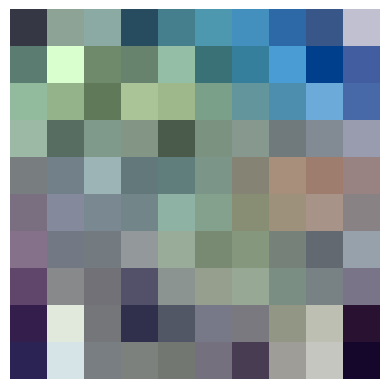

Model accuracy with adversarial patch: 16.09%
Untargeted attack success rate on test set: 83.91%
Epoch 1
Target class: None
Accuracy: 0.4151

Epoch 2
Target class: None
Accuracy: 0.3326

Epoch 3
Target class: None
Accuracy: 0.2947

Epoch 4
Target class: None
Accuracy: 0.2726

Epoch 5
Target class: None
Accuracy: 0.2517

Epoch 6
Target class: None
Accuracy: 0.2549

Epoch 7
Target class: None
Accuracy: 0.2386

Epoch 8
Target class: None
Accuracy: 0.2352

Epoch 9
Target class: None
Accuracy: 0.2286

Epoch 10
Target class: None
Accuracy: 0.2163



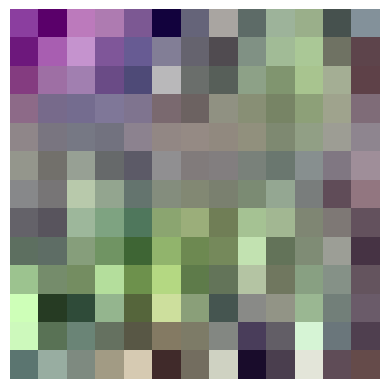

Model accuracy with adversarial patch: 23.93%
Untargeted attack success rate on test set: 76.07%
Epoch 1
Target class: None
Accuracy: 0.3482

Epoch 2
Target class: None
Accuracy: 0.2727

Epoch 3
Target class: None
Accuracy: 0.2442

Epoch 4
Target class: None
Accuracy: 0.1749

Epoch 5
Target class: None
Accuracy: 0.1485

Epoch 6
Target class: None
Accuracy: 0.1366

Epoch 7
Target class: None
Accuracy: 0.1369

Epoch 8
Target class: None
Accuracy: 0.1343

Epoch 9
Target class: None
Accuracy: 0.1332

Epoch 10
Target class: None
Accuracy: 0.1316



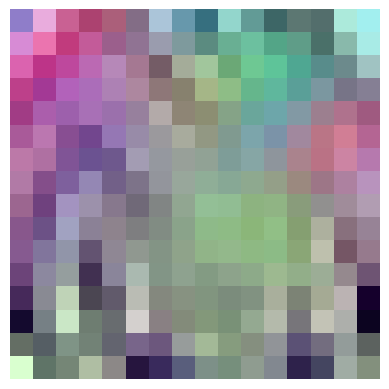

Model accuracy with adversarial patch: 13.66%
Untargeted attack success rate on test set: 86.34%


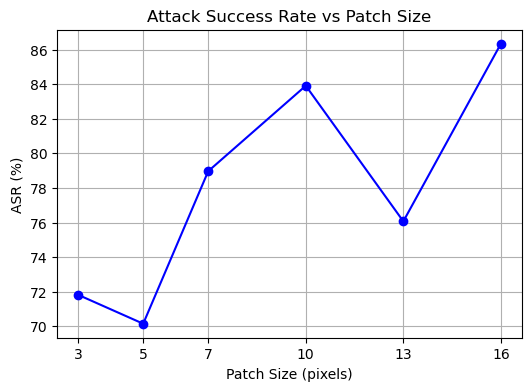

In [14]:
patch_sizes = [3, 5, 7, 10, 13, 16]
untargetted_asr_results = {}
for size in patch_sizes:
  patch = generate_adversarial_patch(model=resnet18, patch_size=size, target_class=None, num_epochs=10, lr=1e-1, momentum=0.8)
  visualize_patch(patch)
  adversarial_accuracy, untargetted_asr = test(model=resnet18, patch=patch, target_class=None)
  untargetted_asr_results[size] = untargetted_asr
plot_asr_vs_patch_size(patch_sizes, untargetted_asr_results)

### Generate patches with side length of 3,5,7,10,13,16. Visualize patch_sizes v.s. targeted ASR. Target class is set to 5 here.

Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 5.88
Accuracy: 0.592

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 21.97
Accuracy: 0.3986

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 30.94
Accuracy: 0.3238

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 35.099999999999994
Accuracy: 0.2824

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 37.51
Accuracy: 0.2559

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 39.15
Accuracy: 0.2376

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 40.48
Accuracy: 0.2323

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 41.199999999999996
Accuracy: 0.2238

Epoch 9
Target class: 5
Percentage of samples predicted as target class 5: 42.1
Accuracy: 0.2234

Epoch 10
Target class: 5
Percentage of samples predicted as target class 5: 43.19
Accu

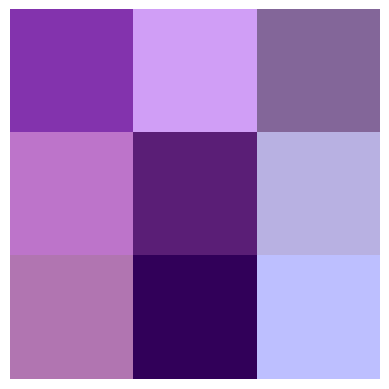

Model accuracy with adversarial patch: 23.14%
Untargeted attack success rate on test set: 76.86%
Targeted attack success rate on test set for class 5: 35.78%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 4.71
Accuracy: 0.5725

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 36.04
Accuracy: 0.3453

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 47.24
Accuracy: 0.2607

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 50.51
Accuracy: 0.2261

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 52.93
Accuracy: 0.2211

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 55.03
Accuracy: 0.2057

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 55.65
Accuracy: 0.1999

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 56.38999999999999
Accuracy: 0.1924

Epoch 9
Target class: 5
Percentage of s

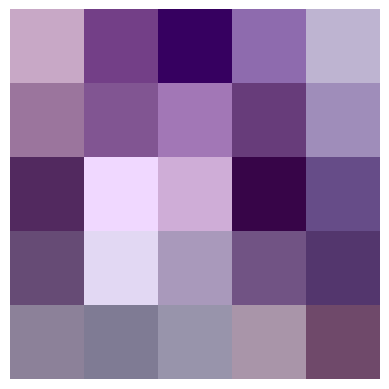

Model accuracy with adversarial patch: 20.00%
Untargeted attack success rate on test set: 80.00%
Targeted attack success rate on test set for class 5: 49.88%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 6.65
Accuracy: 0.511

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 44.81
Accuracy: 0.2938

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 54.790000000000006
Accuracy: 0.2433

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 58.720000000000006
Accuracy: 0.2361

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 61.91
Accuracy: 0.2206

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 64.05
Accuracy: 0.2146

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 65.25999999999999
Accuracy: 0.2046

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 67.38
Accuracy: 0.1976

Epoch 9
Target

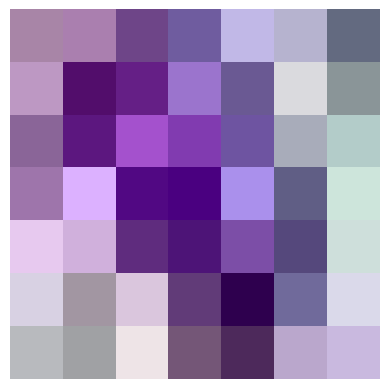

Model accuracy with adversarial patch: 20.93%
Untargeted attack success rate on test set: 79.07%
Targeted attack success rate on test set for class 5: 59.15%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 5.18
Accuracy: 0.4907

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 75.49
Accuracy: 0.2105

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 82.28
Accuracy: 0.177

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 85.50999999999999
Accuracy: 0.1606

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 87.48
Accuracy: 0.1545

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 89.2
Accuracy: 0.1458

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 90.72
Accuracy: 0.1375

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 91.28
Accuracy: 0.1404

Epoch 9
Target class: 5
Percentage of sam

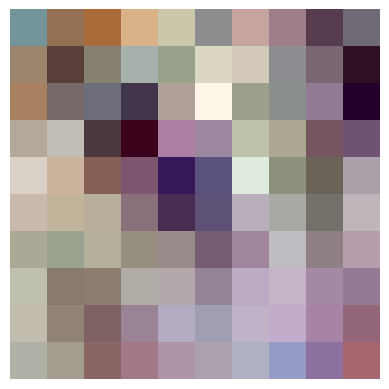

Model accuracy with adversarial patch: 13.51%
Untargeted attack success rate on test set: 86.49%
Targeted attack success rate on test set for class 5: 80.51%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 4.66
Accuracy: 0.4145

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 89.3
Accuracy: 0.1467

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 93.77
Accuracy: 0.1297

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 95.86
Accuracy: 0.1225

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 96.64
Accuracy: 0.1178

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 96.97
Accuracy: 0.1167

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 97.2
Accuracy: 0.1137

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 97.63
Accuracy: 0.1137

Epoch 9
Target class: 5
Percentage of samples predict

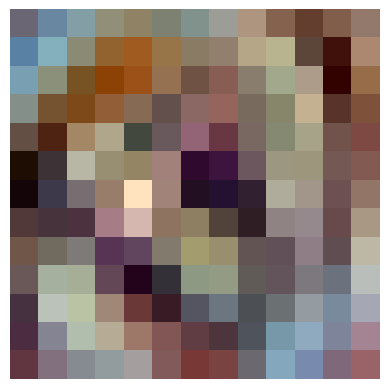

Model accuracy with adversarial patch: 11.19%
Untargeted attack success rate on test set: 88.81%
Targeted attack success rate on test set for class 5: 86.97%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 5.52
Accuracy: 0.3656

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 98.37
Accuracy: 0.111

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 99.0
Accuracy: 0.1076

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 99.31
Accuracy: 0.106

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 99.24
Accuracy: 0.1078

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 99.53
Accuracy: 0.1052

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 99.68
Accuracy: 0.1052

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 99.62
Accuracy: 0.1051

Epoch 9
Target class: 5
Percentage of samples predicte

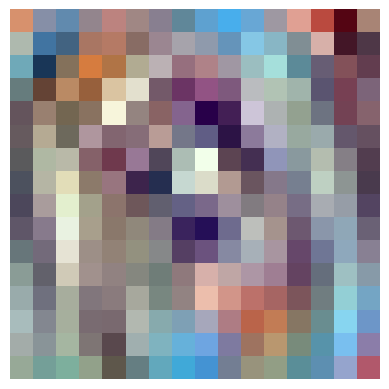

Model accuracy with adversarial patch: 10.13%
Untargeted attack success rate on test set: 89.87%
Targeted attack success rate on test set for class 5: 89.59%


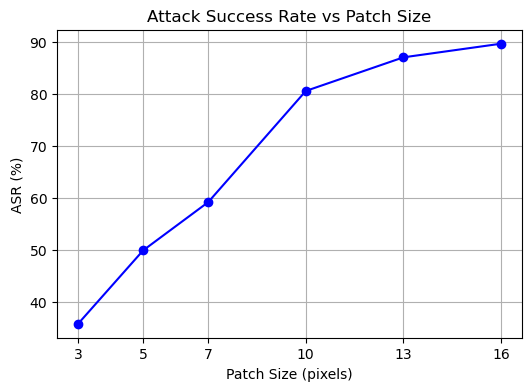

In [15]:
patch_sizes = [3, 5, 7, 10, 13, 16]
targetted_asr_results = {}
for size in patch_sizes:
  patch = generate_adversarial_patch(model=resnet18, patch_size=size, target_class=5, num_epochs=10, lr=1e-1, momentum=0.8)
  visualize_patch(patch)
  adversarial_accuracy, untargetted_asr, targetted_asr = test(model=resnet18, patch=patch, target_class=5)
  targetted_asr_results[size] = targetted_asr
plot_asr_vs_patch_size(patch_sizes, targetted_asr_results)

### Test untarget & target attack on ResNet50, using the 8*8 patch.

In [16]:
# # Load pre-trained model
# resnet50 = models.resnet50(weights="DEFAULT")

# # ResNet is trained on ImageNet, which has 1000 classes
# # So we need to modify the output layer for CIFAR-10, which has 10 classes
# resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)

# # Finetune the model
# fine_tune_for_cifar10(model=resnet50, num_epochs=30, model_path="resnet50.pth")


Epoch 1: Training accuracy = 0.5049
Validation accuracy: 0.6656
Saved new best model with accuracy: 0.6656
Epoch 2: Training accuracy = 0.574475
Validation accuracy: 0.6607
Epoch 3: Training accuracy = 0.6967
Validation accuracy: 0.7399
Saved new best model with accuracy: 0.7399
Epoch 4: Training accuracy = 0.739175
Validation accuracy: 0.7597
Saved new best model with accuracy: 0.7597
Epoch 5: Training accuracy = 0.7605
Validation accuracy: 0.7874
Saved new best model with accuracy: 0.7874
Epoch 6: Training accuracy = 0.7839
Validation accuracy: 0.8058
Saved new best model with accuracy: 0.8058
Epoch 7: Training accuracy = 0.7987
Validation accuracy: 0.7682
Epoch 8: Training accuracy = 0.808225
Validation accuracy: 0.7908
Epoch 9: Training accuracy = 0.8207
Validation accuracy: 0.811
Saved new best model with accuracy: 0.8110
Epoch 10: Training accuracy = 0.827525
Validation accuracy: 0.8183
Saved new best model with accuracy: 0.8183
Epoch 11: Training accuracy = 0.836525
Validation a

(0.2887, 0.7113, 0.162)

In [42]:
# Load pre-trained model
resnet50 = models.resnet50(weights="DEFAULT")

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)
# Load best model checkpoint
resnet50 = load_model(resnet50, "resnet50.pth", device=device)
# Test model performance on clean test dataset
test(model=resnet50, patch=None, target_class=None)

# Untargeted Attack
test(model=resnet50, patch=patch_untarget, target_class=None)
# Targeted Attack
test(model=resnet50, patch=patch_target, target_class=5)

Model accuracy on clean test set: 87.30%
Model accuracy with adversarial patch: 11.28%
Untargeted attack success rate on test set: 88.72%
Model accuracy with adversarial patch: 25.19%
Untargeted attack success rate on test set: 74.81%
Targeted attack success rate on test set for class 5: 17.55%


(0.2519, 0.7481, 0.1755)

### Test untarget & target attack on VGG19

In [18]:
# Load pre-trained model
vgg19 = models.vgg19(weights="DEFAULT")

# Get the number of input features to the classifier
num_features = vgg19.classifier[-1].in_features

# Replace the last layer (classifier) for CIFAR-10, which has 10 classes
vgg19.classifier[-1] = nn.Linear(num_features, 10)

# Finetune the model
fine_tune_for_cifar10(model=vgg19, num_epochs=30, model_path="vgg19.pth")
# Load best model checkpoint
vgg19 = load_model(vgg19, "vgg19.pth")
# Test model performance on clean test dataset
test(model=vgg19, patch=None, target_class=None)

# Untargeted Attack
test(model=vgg19, patch=patch_untarget, target_class=None)
# Targeted Attack
test(model=vgg19, patch=patch_target, target_class=5)

Epoch 1: Training accuracy = 0.5275
Validation accuracy: 0.7048
Saved new best model with accuracy: 0.7048
Epoch 2: Training accuracy = 0.737375
Validation accuracy: 0.7765
Saved new best model with accuracy: 0.7765
Epoch 3: Training accuracy = 0.78545
Validation accuracy: 0.754
Epoch 4: Training accuracy = 0.8114
Validation accuracy: 0.8062
Saved new best model with accuracy: 0.8062
Epoch 5: Training accuracy = 0.827975
Validation accuracy: 0.8081
Saved new best model with accuracy: 0.8081
Epoch 6: Training accuracy = 0.840475
Validation accuracy: 0.8022
Epoch 7: Training accuracy = 0.851325
Validation accuracy: 0.8392
Saved new best model with accuracy: 0.8392
Epoch 8: Training accuracy = 0.863825
Validation accuracy: 0.8489
Saved new best model with accuracy: 0.8489
Epoch 9: Training accuracy = 0.871475
Validation accuracy: 0.8587
Saved new best model with accuracy: 0.8587
Epoch 10: Training accuracy = 0.87895
Validation accuracy: 0.8558
Epoch 11: Training accuracy = 0.88135
Validat

(0.2, 0.8, 0.0788)

### Test untarget & target attack on DenseNet121

In [19]:
# Load pre-trained model
densenet121 = models.densenet121(weights="DEFAULT")

num_features = densenet121.classifier.in_features  # Get the number of input features
densenet121.classifier = nn.Linear(num_features, 10)  # Replace the classifier for CIFAR-10

# Finetune the model
fine_tune_for_cifar10(model=densenet121, num_epochs=30, model_path="densenet121.pth")
# Load best model checkpoint
densenet121 = load_model(densenet121, "densenet121.pth")
# Test model performance on clean test dataset
test(model=densenet121, patch=None, target_class=None)

# Untargeted Attack
test(model=densenet121, patch=patch_untarget, target_class=None)
# Targeted Attack
test(model=densenet121, patch=patch_target, target_class=5)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/jamie/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 77.7MB/s]


Epoch 1: Training accuracy = 0.215075
Validation accuracy: 0.2725
Saved new best model with accuracy: 0.2725
Epoch 2: Training accuracy = 0.2906
Validation accuracy: 0.3427
Saved new best model with accuracy: 0.3427
Epoch 3: Training accuracy = 0.36095
Validation accuracy: 0.3635
Saved new best model with accuracy: 0.3635
Epoch 4: Training accuracy = 0.391225
Validation accuracy: 0.4132
Saved new best model with accuracy: 0.4132
Epoch 5: Training accuracy = 0.418175
Validation accuracy: 0.4053
Epoch 6: Training accuracy = 0.443925
Validation accuracy: 0.4458
Saved new best model with accuracy: 0.4458
Epoch 7: Training accuracy = 0.4673
Validation accuracy: 0.4831
Saved new best model with accuracy: 0.4831
Epoch 8: Training accuracy = 0.4839
Validation accuracy: 0.4772
Epoch 9: Training accuracy = 0.494725
Validation accuracy: 0.5023
Saved new best model with accuracy: 0.5023
Epoch 10: Training accuracy = 0.510225
Validation accuracy: 0.5168
Saved new best model with accuracy: 0.5168
Ep

(0.2334, 0.7666, 0.325)

In [43]:
from tabulate import tabulate

# Define the table data
table_data = [
    ["Model", "Untargeted ASR", "Targeted ASR"],
    ["ResNet50", 0.74811, 0.1755],
    ["DenseNet121", 0.7666, 0.3250],
    ["VGG19", 0.800, 0.0788]

]

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))


+-------------+------------------+----------------+
| Model       |   Untargeted ASR |   Targeted ASR |
+=============+==================+================+
| ResNet50    |          0.74811 |         0.1755 |
+-------------+------------------+----------------+
| DenseNet121 |          0.7666  |         0.325  |
+-------------+------------------+----------------+
| VGG19       |          0.8     |         0.0788 |
+-------------+------------------+----------------+


### Extension: more Data Augmentation: horizontal flips, vertical flips, and color inversions.

In [44]:
# Apply patch to a batch of images with additional transformations (rotation, horizontal flip, vertical flip, color inversion)
def apply_extension(patch, batch_of_images):
    num_images = batch_of_images.shape[0]
    patch_size = patch.shape[1]  
    
    # Iterate through each image in the batch
    for i in range(num_images):
        # Rotate the patch by a random number of degrees
        degree = random.uniform(0, 360)
        patch_rotated = TF.rotate(patch, angle=degree)

        # Apply horizontal flip with 50% probability
        if random.random() > 0.5:
            patch_rotated = TF.hflip(patch_rotated)
        
        # Apply vertical flip with 50% probability
        if random.random() > 0.5:
            patch_rotated = TF.vflip(patch_rotated)

        # Apply color inversion with 50% probability
        if random.random() > 0.5:
            patch_rotated = TF.invert(patch_rotated)

        # Randomly choose an (x, y) coordinate on the 32x32 CIFAR-10 image
        # This coordinate will be where the top left corner of the rotated patch goes
        top_left_x = random.randint(0, 31 - patch_size)
        top_left_y = random.randint(0, 31 - patch_size)

        # Apply the randomly transformed patch at the random location
        batch_of_images[i, :, top_left_x:top_left_x+patch_size, top_left_y:top_left_y+patch_size] = patch_rotated

    return batch_of_images


In [ ]:
# Load pre-trained model
resnet18ex = models.resnet18(weights="DEFAULT")

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
resnet18ex.fc = nn.Linear(resnet18ex.fc.in_features, 10)

# Finetune the model
fine_tune_for_cifar10(model=resnet18ex, num_epochs=30, model_path="resnet18ex.pth")
# Load best model checkpoint
resnet18ex = load_model(resnet18ex, "resnet18ex.pth", device=device)
# Test model performance on clean test dataset
test(model=resnet18ex, patch=None, target_class=None)

Epoch 1
Target class: None
Accuracy: 0.5416

Epoch 2
Target class: None
Accuracy: 0.4188

Epoch 3
Target class: None
Accuracy: 0.3621

Epoch 4
Target class: None
Accuracy: 0.3208

Epoch 5
Target class: None
Accuracy: 0.2961

Epoch 6
Target class: None
Accuracy: 0.2738

Epoch 7
Target class: None
Accuracy: 0.2575

Epoch 8
Target class: None
Accuracy: 0.25

Epoch 9
Target class: None
Accuracy: 0.2404

Epoch 10
Target class: None
Accuracy: 0.2234



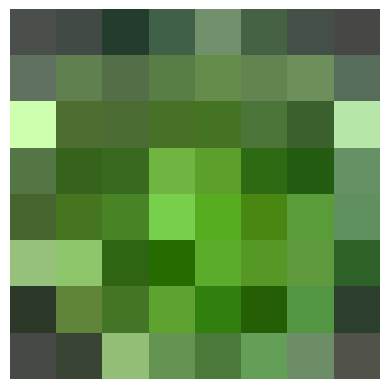

Model accuracy with adversarial patch: 24.15%
Untargeted attack success rate on test set: 75.85%


(0.2415, 0.7585)

In [54]:
# Generate adversarial patch
patch_untarget = generate_adversarial_patch(model=resnet18, patch_size=8, target_class=None, num_epochs=10, lr=1e-1, momentum=0.8, apply=apply_extension)
# Visualize the generated patch
visualize_patch(patch_untarget)
# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_untarget, target_class=None, apply=apply_extension)

Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 7.93
Accuracy: 0.544

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 12.3
Accuracy: 0.3323

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 11.790000000000001
Accuracy: 0.2445

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 11.75
Accuracy: 0.2075

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 10.35
Accuracy: 0.1916

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 9.99
Accuracy: 0.1773

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 9.73
Accuracy: 0.173

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 9.879999999999999
Accuracy: 0.1674

Epoch 9
Target class: 5
Percentage of samples predicted as target class 5: 9.370000000000001
Accuracy: 0.1628

Epoch 10
Target class: 5
Percentage of samples predicted as target class 5: 9.

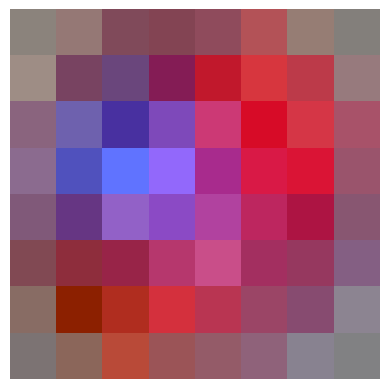

Model accuracy with adversarial patch: 20.39%
Untargeted attack success rate on test set: 79.61%
Targeted attack success rate on test set for class 5: 11.67%


(0.2039, 0.7961, 0.1167)

In [55]:
# Generate adversarial patch
patch_target = generate_adversarial_patch(model=resnet18, patch_size=8, target_class=5, num_epochs=10, lr=1e-1, momentum=0.8, apply=apply_extension)
# Visualize the generated patch
visualize_patch(patch_target)
# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_target, target_class=5, apply=apply_extension)

### (Extension) Generate patches with side length of 3,5,7,10,13,16. Visualize patch_sizes v.s. untargeted ASR. 

Epoch 1
Target class: None
Accuracy: 0.59

Epoch 2
Target class: None
Accuracy: 0.443

Epoch 3
Target class: None
Accuracy: 0.3887

Epoch 4
Target class: None
Accuracy: 0.3536

Epoch 5
Target class: None
Accuracy: 0.3279

Epoch 6
Target class: None
Accuracy: 0.3088

Epoch 7
Target class: None
Accuracy: 0.285

Epoch 8
Target class: None
Accuracy: 0.2742

Epoch 9
Target class: None
Accuracy: 0.2715

Epoch 10
Target class: None
Accuracy: 0.2548



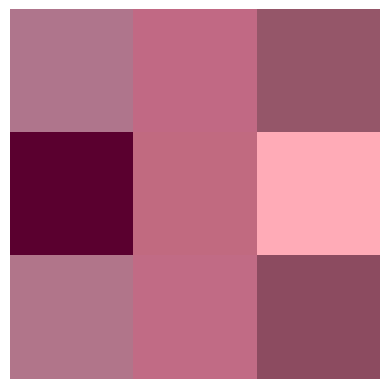

Model accuracy with adversarial patch: 28.58%
Untargeted attack success rate on test set: 71.42%
Epoch 1
Target class: None
Accuracy: 0.5443

Epoch 2
Target class: None
Accuracy: 0.4676

Epoch 3
Target class: None
Accuracy: 0.4104

Epoch 4
Target class: None
Accuracy: 0.3602

Epoch 5
Target class: None
Accuracy: 0.3344

Epoch 6
Target class: None
Accuracy: 0.3133

Epoch 7
Target class: None
Accuracy: 0.2888

Epoch 8
Target class: None
Accuracy: 0.2681

Epoch 9
Target class: None
Accuracy: 0.2504

Epoch 10
Target class: None
Accuracy: 0.2443



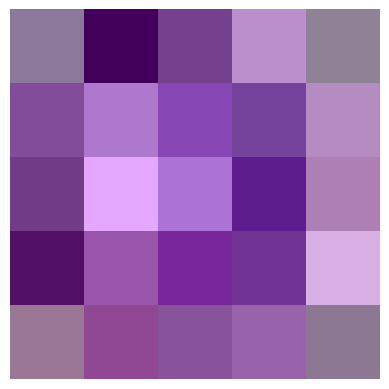

Model accuracy with adversarial patch: 29.53%
Untargeted attack success rate on test set: 70.47%
Epoch 1
Target class: None
Accuracy: 0.5352

Epoch 2
Target class: None
Accuracy: 0.3878

Epoch 3
Target class: None
Accuracy: 0.3408

Epoch 4
Target class: None
Accuracy: 0.2939

Epoch 5
Target class: None
Accuracy: 0.2694

Epoch 6
Target class: None
Accuracy: 0.2553

Epoch 7
Target class: None
Accuracy: 0.2362

Epoch 8
Target class: None
Accuracy: 0.2263

Epoch 9
Target class: None
Accuracy: 0.2177

Epoch 10
Target class: None
Accuracy: 0.197



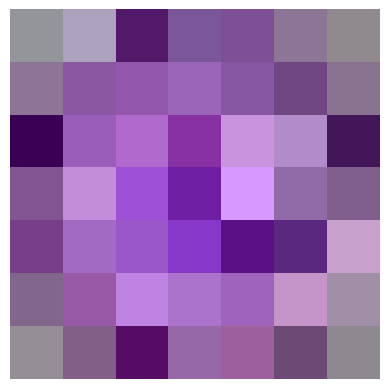

Model accuracy with adversarial patch: 25.72%
Untargeted attack success rate on test set: 74.28%
Epoch 1
Target class: None
Accuracy: 0.4514

Epoch 2
Target class: None
Accuracy: 0.3904

Epoch 3
Target class: None
Accuracy: 0.3567

Epoch 4
Target class: None
Accuracy: 0.3328

Epoch 5
Target class: None
Accuracy: 0.2995

Epoch 6
Target class: None
Accuracy: 0.296

Epoch 7
Target class: None
Accuracy: 0.2805

Epoch 8
Target class: None
Accuracy: 0.2677

Epoch 9
Target class: None
Accuracy: 0.2594

Epoch 10
Target class: None
Accuracy: 0.2477



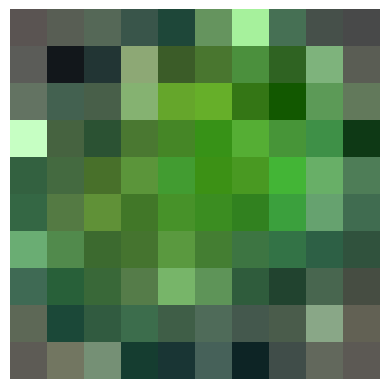

Model accuracy with adversarial patch: 26.31%
Untargeted attack success rate on test set: 73.69%
Epoch 1
Target class: None
Accuracy: 0.4169

Epoch 2
Target class: None
Accuracy: 0.3037

Epoch 3
Target class: None
Accuracy: 0.2565

Epoch 4
Target class: None
Accuracy: 0.2302

Epoch 5
Target class: None
Accuracy: 0.2176

Epoch 6
Target class: None
Accuracy: 0.214

Epoch 7
Target class: None
Accuracy: 0.2027

Epoch 8
Target class: None
Accuracy: 0.1938

Epoch 9
Target class: None
Accuracy: 0.1853

Epoch 10
Target class: None
Accuracy: 0.1859



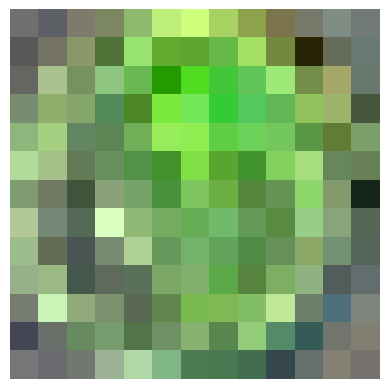

Model accuracy with adversarial patch: 20.11%
Untargeted attack success rate on test set: 79.89%
Epoch 1
Target class: None
Accuracy: 0.3607

Epoch 2
Target class: None
Accuracy: 0.2763

Epoch 3
Target class: None
Accuracy: 0.2531

Epoch 4
Target class: None
Accuracy: 0.2259

Epoch 5
Target class: None
Accuracy: 0.2076

Epoch 6
Target class: None
Accuracy: 0.1893

Epoch 7
Target class: None
Accuracy: 0.1769

Epoch 8
Target class: None
Accuracy: 0.1695

Epoch 9
Target class: None
Accuracy: 0.1614

Epoch 10
Target class: None
Accuracy: 0.149



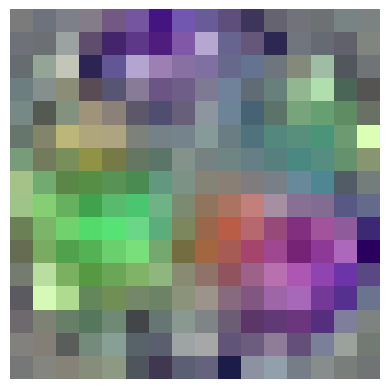

Model accuracy with adversarial patch: 20.45%
Untargeted attack success rate on test set: 79.55%


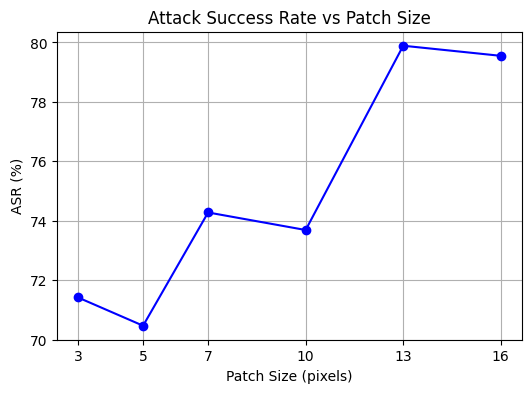

In [56]:
patch_sizes = [3, 5, 7, 10, 13, 16]
untargetted_asr_results = {}
for size in patch_sizes:
  patch = generate_adversarial_patch(model=resnet18, patch_size=size, target_class=None, num_epochs=10,\
                                      lr=1e-1, momentum=0.8, apply=apply_extension)
  visualize_patch(patch)
  adversarial_accuracy, untargetted_asr = test(model=resnet18, patch=patch, target_class=None, apply=apply_extension)
  untargetted_asr_results[size] = untargetted_asr
plot_asr_vs_patch_size(patch_sizes, untargetted_asr_results)

### (Extension) Generate patches with side length of 3,5,7,10,13,16. Visualize patch_sizes v.s. targeted ASR. Target class is set to 5 here. 

Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 7.53
Accuracy: 0.5822

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 8.48
Accuracy: 0.3632

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 7.580000000000001
Accuracy: 0.2914

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 7.85
Accuracy: 0.2497

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 7.4399999999999995
Accuracy: 0.23

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 7.049999999999999
Accuracy: 0.2102

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 7.6899999999999995
Accuracy: 0.2019

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 7.31
Accuracy: 0.1996

Epoch 9
Target class: 5
Percentage of samples predicted as target class 5: 7.85
Accuracy: 0.1967

Epoch 10
Target class: 5
Percentage of samples predicted as target

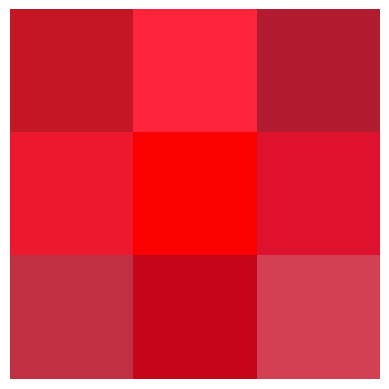

Model accuracy with adversarial patch: 22.40%
Untargeted attack success rate on test set: 77.60%
Targeted attack success rate on test set for class 5: 9.14%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 4.93
Accuracy: 0.5772

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 11.78
Accuracy: 0.3929

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 15.559999999999999
Accuracy: 0.3057

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 17.28
Accuracy: 0.2635

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 19.02
Accuracy: 0.2438

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 19.49
Accuracy: 0.2301

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 19.77
Accuracy: 0.2232

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 19.830000000000002
Accuracy: 0.2067

Epoch 9
Target class: 5
Pe

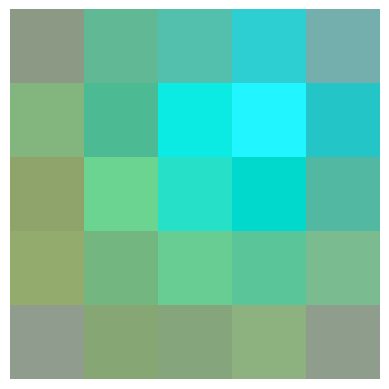

Model accuracy with adversarial patch: 20.02%
Untargeted attack success rate on test set: 79.98%
Targeted attack success rate on test set for class 5: 8.94%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 5.9799999999999995
Accuracy: 0.5528

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 8.3
Accuracy: 0.3476

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 7.16
Accuracy: 0.2578

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 7.21
Accuracy: 0.2101

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 6.93
Accuracy: 0.196

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 7.870000000000001
Accuracy: 0.1816

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 7.32
Accuracy: 0.1703

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 7.920000000000001
Accuracy: 0.1681

Epoch 9
Target class:

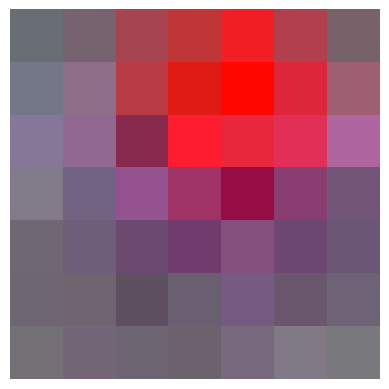

Model accuracy with adversarial patch: 19.96%
Untargeted attack success rate on test set: 80.04%
Targeted attack success rate on test set for class 5: 10.01%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 4.8
Accuracy: 0.4939

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 16.24
Accuracy: 0.3052

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 17.96
Accuracy: 0.2435

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 19.02
Accuracy: 0.2168

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 19.48
Accuracy: 0.2086

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 21.3
Accuracy: 0.2005

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 21.3
Accuracy: 0.2012

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 21.88
Accuracy: 0.1995

Epoch 9
Target class: 5
Percentage of samples predicte

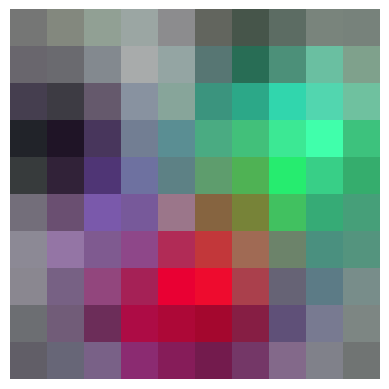

Model accuracy with adversarial patch: 21.58%
Untargeted attack success rate on test set: 78.42%
Targeted attack success rate on test set for class 5: 13.42%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 4.3
Accuracy: 0.3954

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 59.260000000000005
Accuracy: 0.2541

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 63.72
Accuracy: 0.2276

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 66.47
Accuracy: 0.2093

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 68.44
Accuracy: 0.2005

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 70.00999999999999
Accuracy: 0.1993

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 72.25
Accuracy: 0.1867

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 73.26
Accuracy: 0.1827

Epoch 9
Target class: 5
Per

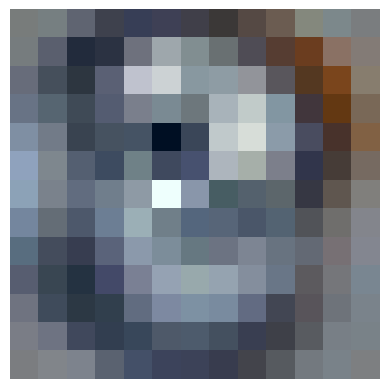

Model accuracy with adversarial patch: 18.19%
Untargeted attack success rate on test set: 81.81%
Targeted attack success rate on test set for class 5: 63.15%
Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 1.4500000000000002
Accuracy: 0.3229

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 91.35
Accuracy: 0.1324

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 92.31
Accuracy: 0.129

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 92.67
Accuracy: 0.1307

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 92.91
Accuracy: 0.1265

Epoch 6
Target class: 5
Percentage of samples predicted as target class 5: 93.08
Accuracy: 0.1275

Epoch 7
Target class: 5
Percentage of samples predicted as target class 5: 93.5
Accuracy: 0.1272

Epoch 8
Target class: 5
Percentage of samples predicted as target class 5: 93.26
Accuracy: 0.1245

Epoch 9
Target class: 5
Percentage of s

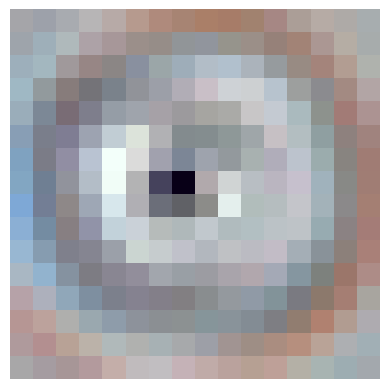

Model accuracy with adversarial patch: 12.68%
Untargeted attack success rate on test set: 87.32%
Targeted attack success rate on test set for class 5: 81.46%


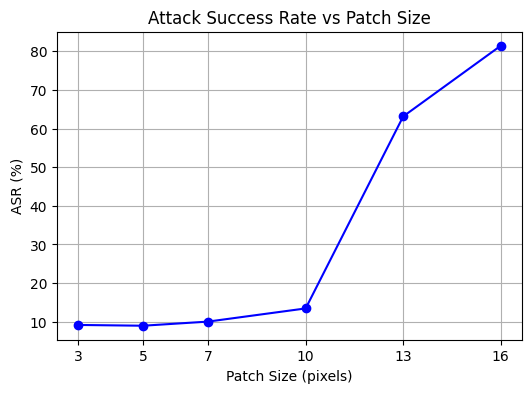

In [59]:
patch_sizes = [3, 5, 7, 10, 13, 16]
targetted_asr_results = {}
for size in patch_sizes:
  patch = generate_adversarial_patch(model=resnet18, patch_size=size, target_class=5, num_epochs=10, \
                                     lr=1e-1, momentum=0.8, apply=apply_extension)
  visualize_patch(patch)
  adversarial_accuracy, untargetted_asr, targetted_asr = test(model=resnet18, patch=patch, target_class=5, apply=apply_extension)
  targetted_asr_results[size] = targetted_asr
plot_asr_vs_patch_size(patch_sizes, targetted_asr_results)

In [57]:
# Load pre-trained model
resnet18ex = models.resnet18(weights="DEFAULT")

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
resnet18ex.fc = nn.Linear(resnet18ex.fc.in_features, 10)
# Load best model checkpoint
resnet18ex = load_model(resnet18ex, "resnet18.pth", device=device)
# Test model performance on clean test dataset
test(model=resnet18ex, patch=None, target_class=None, apply=apply_extension)

# Untargeted Attack
test(model=resnet18ex, patch=patch_untarget, target_class=None, apply=apply_extension)


Model accuracy on clean test set: 82.36%
Model accuracy with adversarial patch: 14.82%
Untargeted attack success rate on test set: 85.18%


(0.1482, 0.8518)

In [58]:
# Targeted Attack
test(model=resnet18ex, patch=patch_target, target_class=5, apply=apply_extension)

Model accuracy with adversarial patch: 12.12%
Untargeted attack success rate on test set: 87.88%
Targeted attack success rate on test set for class 5: 19.06%


(0.1212, 0.8788, 0.1906)

In [62]:
# Load pre-trained model
vgg19 = models.vgg19(weights="DEFAULT")

# Get the number of input features to the classifier
num_features = vgg19.classifier[-1].in_features

# Replace the last layer (classifier) for CIFAR-10, which has 10 classes
vgg19.classifier[-1] = nn.Linear(num_features, 10)

# Finetune the model
# fine_tune_for_cifar10(model=vgg19, num_epochs=30, model_path="vgg19.pth")
# Load best model checkpoint
vgg19 = load_model(vgg19, "vgg19.pth", device=device)
# Test model performance on clean test dataset
test(model=vgg19, patch=None, target_class=None, apply=apply_extension)

# Untargeted Attack
test(model=vgg19, patch=patch_untarget, target_class=None, apply=apply_extension)
# Targeted Attack
test(model=vgg19, patch=patch_target, target_class=5, apply=apply_extension)

Model accuracy on clean test set: 88.50%
Model accuracy with adversarial patch: 20.63%
Untargeted attack success rate on test set: 79.37%
Model accuracy with adversarial patch: 18.01%
Untargeted attack success rate on test set: 81.99%
Targeted attack success rate on test set for class 5: 0.17%


(0.1801, 0.8199, 0.0017)

In [63]:
# Load pre-trained model
densenet121 = models.densenet121(weights="DEFAULT")

num_features = densenet121.classifier.in_features  # Get the number of input features
densenet121.classifier = nn.Linear(num_features, 10)  # Replace the classifier for CIFAR-10

# Finetune the model
# fine_tune_for_cifar10(model=densenet121, num_epochs=30, model_path="densenet121.pth")
# Load best model checkpoint
densenet121 = load_model(densenet121, "densenet121.pth", device=device)
# Test model performance on clean test dataset
test(model=densenet121, patch=None, target_class=None, apply=apply_extension)

# Untargeted Attack
test(model=densenet121, patch=patch_untarget, target_class=None, apply=apply_extension)
# Targeted Attack
test(model=densenet121, patch=patch_target, target_class=5, apply=apply_extension)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/hiepnguyen/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100.0%


Model accuracy on clean test set: 67.30%
Model accuracy with adversarial patch: 20.83%
Untargeted attack success rate on test set: 79.17%
Model accuracy with adversarial patch: 16.84%
Untargeted attack success rate on test set: 83.16%
Targeted attack success rate on test set for class 5: 2.80%


(0.1684, 0.8316, 0.028)

In [64]:
# Load pre-trained model
resnet50 = models.resnet50(weights="DEFAULT")

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)
# Load best model checkpoint
resnet50 = load_model(resnet50, "resnet50.pth", device=device)
# Test model performance on clean test dataset
test(model=resnet50, patch=None, target_class=None, apply=apply_extension)

# Untargeted Attack
test(model=resnet50, patch=patch_untarget, target_class=None, apply=apply_extension)
# Targeted Attack
test(model=resnet50, patch=patch_target, target_class=5, apply=apply_extension)

Model accuracy on clean test set: 87.30%
Model accuracy with adversarial patch: 18.87%
Untargeted attack success rate on test set: 81.13%
Model accuracy with adversarial patch: 15.94%
Untargeted attack success rate on test set: 84.06%
Targeted attack success rate on test set for class 5: 7.27%


(0.1594, 0.8406, 0.0727)

In [66]:
# Define the table data
table_data = [
    ["Model", "Untargeted ASR", "Targeted ASR"],
    ["ResNet18", 0.8788, 0.1906],
    ["ResNet50", 0.8406, 0.0727],
    ["DenseNet121", 0.8316, 0.028],
    ["VGG19", 0.8199, 0.0017]

]

# Print the table
print("With extended data augmentation:")
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

With extended data augmentation:
+-------------+------------------+----------------+
| Model       |   Untargeted ASR |   Targeted ASR |
+=============+==================+================+
| ResNet18    |           0.8788 |         0.1906 |
+-------------+------------------+----------------+
| ResNet50    |           0.8406 |         0.0727 |
+-------------+------------------+----------------+
| DenseNet121 |           0.8316 |         0.028  |
+-------------+------------------+----------------+
| VGG19       |           0.8199 |         0.0017 |
+-------------+------------------+----------------+
